# Detect boxes in a single image

Simple script that detects all bounding boxes over a threshold defined in the model's `pipeline.cfg` file. For now the models only work on pretrained classes from the COCO dataset. Some explanations on tensorflow concepts follow. This script has been tested on on all models in `"Aditionals Detection/models"`. Some are fast but innacurate, some are more accurate but slower.

### general module imports

In [1]:
import os
import sys
import time
from distutils.version import StrictVersion

import six.moves.urllib as urllib
import tarfile
import zipfile
from io import StringIO
from collections import defaultdict

import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt
from PIL import Image

# folders "object_detection" and "object_detection/slim" must be listed in PATH
sys.path.append("..")
sys.path.append("../object_detection")


if StrictVersion(tf.__version__) < StrictVersion('1.9.0'):
    raise ImportError('Please upgrade your TensorFlow installation to v1.9.* or later!')


In [2]:
# This is needed to display the images in jupyter notebook
%matplotlib inline

### object_detection api script imports

In [3]:
from object_detection.utils import ops as utils_ops
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as vis_util

### general paths

`MODEL_NAME` is the name of the currently used folder (name of folder in MODEL_PATH). Set to anything in `MODELS` dict

`MODEL_PATH` is the path to all model files

`LABEL_PATH` points to labels.pbtxt with class names.
we are currently using the coco dataset for testing


paths are local to current directory (`"Aditionals Detection/myscripts"`)


**TODO** learn how to make/automate the process of making labels.pbtxt for custom data

In [4]:
MODELS = {
    'ssd_resnet50'           : "ssd_resnet50_v1_fpn",
    'frcnn_resnet101'        : "faster_rcnn_resnet101",
    'frcnn_inception_atrous' : "faster_rcnn_inception_resnet_v2_atrous"
}

MODEL_NAME = MODELS['frcnn_inception_atrous']
MODEL_PATH = "../models/"
PATH_TO_FROZEN_GRAPH = MODEL_PATH + MODEL_NAME + "/" + "frozen_inference_graph.pb"


PATH_TO_LABELS = "../object_detection/data/mscoco_label_map.pbtxt"

### map category indices (integers) to category objects

here we just convert the labels.pbtxt file to dictionary that maps category indices to category objects (dicts):

```
int: {
    'id' : int,
    'name' : string
}
```

**TODO** make a custom tool for that. we are currently using a premade tool to convert the coco dataset labels to names

In [5]:
# use_display_name=False replaces human readable class names with junk strings
category_name_dict = label_map_util.create_category_index_from_labelmap(PATH_TO_LABELS, use_display_name=True)

### load the frozen tf graph into memory

for now this is the defaultly trained coco graph. later we will use our trained checkpoints to create the frozen graph

In [6]:
detection_graph = tf.Graph()
with detection_graph.as_default():
    loaded_detection_graph_def = tf.GraphDef()
    with tf.gfile.GFile(PATH_TO_FROZEN_GRAPH, 'rb') as f:
        # our graph is stored in binary format (or "serialized")
        serialized_graph = f.read()
        loaded_detection_graph_def.ParseFromString(serialized_graph)
        tf.import_graph_def(loaded_detection_graph_def, name="")

### run inference for single image

This function takes in an image, runs the network on it and returns the image with bounding boxes drawn over it

Short explanation of the function...

- Create a graph context, to bind all future Variables and Tensors to loaded frozen graph
- Create a session context, object that encapulates all computations that will be done (by calling sess.run())
- Get handles to output tensors we need to draw boxes
- Run the computation. we input handles for tensors that we want to get computed, session.run() runs until all of those are computed once. we also need to supply a numpy array as an input to our network
- Convert output dict to useful types

**TODO**
- make the function output resulting data as well as image
- make it work on video
- make it work on folder of images

#### On tensors
Tensors are representations of n-dimensional arrays. Networks are represented with tensors and functions connecting tensors together. By convention, all tensors have one extra axis that represents the n-th batch of the image processed to allow processing multiple images at the same time

- Input tensor = image(s)
    - input image, input a numpy array of dimensions `[1, image_width, image_height, 3]`
        - 0th axis is the index of the image in the batch
        - 3rd axis is the channel number of the image (tensorflow takes in RGB)
    - because this script processes a single image, input image must be expanded to have axis 0 (batch dimension)
- Output tensors
    - num_detections
        - number of detected boxes in image, integer `[1]` (batch size dimension)
    - detection_boxes
        - coordinates of the boxes, dimensions `[1, num_detections, 4]`
        - coordinates are stored in list: `[y_min, x_min, y_max, x_max]`
    - detection_scores
        - score (certainty) for the n-th box (+ batch dimension)
    - detection_classes
        - class id for the n-th box (+ batch dimension)

In [16]:
def predict_single_image(image, graph):
    
    # this sets the default tensorflow context
    # define all subsequent tensors and operations in 'active_graph'
    with graph.as_default() as active_graph:
        # define the environment that encapsulates the execution of operations
        with tf.Session() as sess:
            # get handles for input and output tensors...
            
            # put output tensor handles into a dict
            output_tensor_dict = {}
            
            # names of output tensors we need to draw boxes
            output_tensor_names = ('num_detections',    # how many boxes detected in image
                                   'detection_boxes',   # box coordinates [y_min, x_min, y_max, x_max]
                                   'detection_scores',  # score of box
                                   'detection_classes') # class of box
            
            for name in output_tensor_names:
                tensor_name = name + ":0"
                tensor_dict[name] = active_graph.get_tensor_by_name(tensor_name)
                
            # turn image into one-image-batch, because that is the tensor input
            # we actually do this outside the function
            # image = np.expand_dims(image, axis=0)
                
            # input tensor handle
            image_tensor_handle = active_graph.get_tensor_by_name('image_tensor:0')
            
            # run inference
            output_dict = sess.run(tensor_dict,
                                   feed_dict={ image_tensor_handle: image })
                
            # all outputs are float32 np arrays, convert if needed
            output_dict['num_detections']      = int(output_dict['num_detections'][0])
            output_dict['detection_classes']   = output_dict['detection_classes'][0].astype(np.uint8)
            output_dict['detection_boxes']     = output_dict['detection_boxes'][0]
            output_dict['detection_scores']    = output_dict['detection_scores'][0]
                    
            return output_dict
    
    # error return
    return None
            

### helper code for image loading

In [17]:
def image_to_numpy_array(image):
    (im_width, im_height) = image.size
    np_array = np.array(image.getdata())
    np_array = np_array.reshape((im_height, im_width, 3))
    np_array = np_array.astype(np.uint8)
    return np_array

### test the function on some sample data

we use images in the junk folder in `"myscripts/image_junk"`

time elapsed: 57.62587237358093


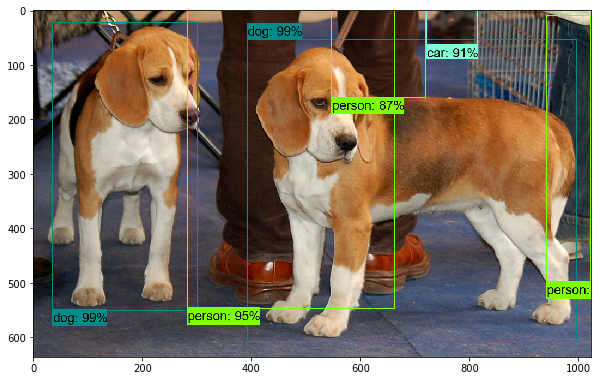

time elapsed: 53.63591551780701


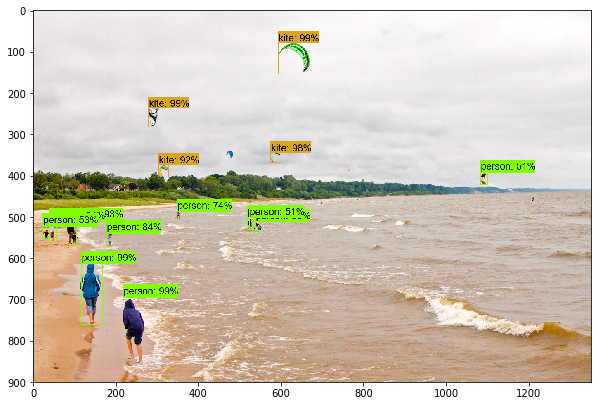

time elapsed: 51.64469814300537


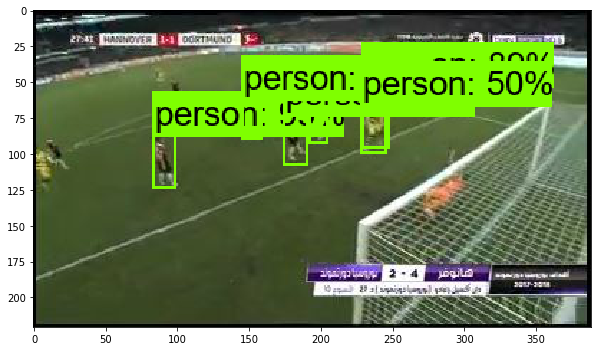

In [18]:
IMAGE_DIR_PATH = "image_junk"

for image_path in os.listdir(IMAGE_DIR_PATH):
    if '.txt' in image_path: continue
    
    start = time.time()
    
    image_path = IMAGE_DIR_PATH + image_path
    image = Image.open(image_path)
    
    # convert to np array so we can draw boxes on image
    image_np = image_to_numpy_array(image)
    #plt.imshow(image_np)
    
    # model expects images to be of shape [1, None, None, 3]
    # 1 represents images in the batch
    # 3 is rgb
    image_np_expanded = np.expand_dims(image_np, axis=0)
    
    # detect!
    output_dict = predict_single_image(image_np_expanded, detection_graph)
    
    end = time.time()
    print("time elapsed:", end - start)
    
    # visualise boxes on image
    vis_util.visualize_boxes_and_labels_on_image_array(
        image_np,
        output_dict['detection_boxes'],
        output_dict['detection_classes'],
        output_dict['detection_scores'],
        category_name_dict,
        instance_masks=output_dict.get('detection_masks'),
        use_normalized_coordinates=True,
        line_thickness=2)
    
    %matplotlib inline # doesn't render images without this...
    plt.figure(figsize=(10,10)) # a size
    plt.imshow(image_np)
    plt.show()

run the computation only for dog image, for easy `output_dict` debugging

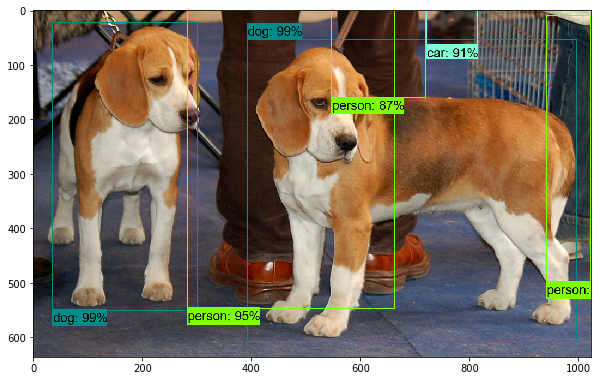

{'num_detections': 6,
 'detection_boxes': array([[0.03769468, 0.03447314, 0.86446667, 0.29545096],
        [0.0858281 , 0.38368925, 0.95539653, 0.97553694],
        [0.00152715, 0.27545547, 0.8595205 , 0.64836776],
        [0.00133795, 0.70430446, 0.10286392, 0.79659086],
        [0.0026666 , 0.53504634, 0.25252572, 0.7046934 ],
        [0.01633718, 0.9194446 , 0.78361017, 1.        ],
        [0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        

In [19]:
# just the dog

dog_img = Image.open("../object_detection/test_images/image1.jpg")
dog_img_np = image_to_numpy_array(dog_img)
dog_img_np_expanded = np.expand_dims(dog_img_np, axis=0)

output_dict = predict_single_image(dog_img_np_expanded, detection_graph)

vis_util.visualize_boxes_and_labels_on_image_array(
        dog_img_np,
        output_dict['detection_boxes'],
        output_dict['detection_classes'],
        output_dict['detection_scores'],
        category_name_dict,
        instance_masks=output_dict.get('detection_masks'),
        use_normalized_coordinates=True,
        line_thickness=2)

plt.figure(figsize=(10,10)) # a size
plt.imshow(dog_img_np)
plt.show()

output_dict